<a href="https://colab.research.google.com/github/EhsanRAmoli/WCE_Deep-learning/blob/main/kfold_angio_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies & tools

In [ ]:
# %tensorflow_version 1.x magic
# import tensorflow as tf
# %tf_version 1.14.0
# tensorflow_version=1.14
from tensorflow import keras
# from tensorflow import keras
print('keras_ versio:', keras.__version__)
# print('tf_version:', tf.__version__)
 
# !cp -r path/to/google_drive_data_dir/ path/to/colab_data_dir 
 
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

keras_ versio: 2.11.0
Sat Feb 11 07:30:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                  

In [ ]:
!pip install tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount("/drive", force_remount=True)

Mounted at /drive


In [ ]:
# %tensorflow_version 1.x magic
import tensorflow as tf
# %tf_version 1.14.0
# tensorflow_version=1.14
from tensorflow import keras
import keras
print(keras.__version__)
print(tf.__version__)

# from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import optimizers, losses
import os, shutil
from keras import models
from keras import activations
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers import AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LayerNormalization, BatchNormalization
# from keras.layers.normalization import 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l2
from keras.layers.convolutional import SeparableConv2D
from keras import backend as K
from keras import utils
from keras.models import  Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers



original_dataset_dir= "/drive/My Drive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION"
base_dir= "/drive/My Drive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia"
# os.mkdir(base_dir)
print(os.listdir(original_dataset_dir))
# print(len(os.listdir("/drive/My Drive/MESSIDOR/P10")))
print(os.listdir(base_dir))

2.11.0
2.11.0
['angiodysplasia']
['validation', 'test', 'train72', 'train', 'main_data', 'test_pathology', 'test_new', 'test_ulcer', 'test_erosion', 'test_blood', 'test_polyp', 'test_erythematous', 'test_lymphoidhyperplasia', 'test_normal', 'test_angiectasia', 'validation_angiectasia', 'test_angiectasia_150', 'saved_models', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5']


In [ ]:
architecture= input('Enter the architecture name:')
trial_number=input('define the version: \n')
# 15

Enter the architecture name:vgg16
define the version: 
15


# data directory

In [ ]:
fold_number= input('define the fold number: \n')

define the fold number: 
1


In [ ]:
original_dataset_dir= "/drive/My Drive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION"
base_dir= f"/drive/My Drive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/fold_{fold_number}"


# os.mkdir(base_dir)
print(os.listdir(original_dataset_dir))
# print(len(os.listdir("/drive/My Drive/MESSIDOR/P10")))
print(os.listdir(base_dir))

train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')

train_normal_dir = os.path.join(train_dir,'Normal')
train_vlesion_dir= os.path.join(train_dir,'Vascular_lesion')
train_inflamatory_dir = os.path.join(train_dir,'Inflammatory')
train_angiectasia_dir = os.path.join(train_dir,'Angiectasia')
print("train directory: ", os.listdir(train_dir))

test_normal_dir = os.path.join(test_dir,'Normal')
test_vlesion_dir = os.path.join(test_dir,'Vascular_lesion')
test_inflamatory_dir= os.path.join(test_dir,'Inflammatory')
test_angiectasia_dir= os.path.join(test_dir,'Angiectasia')
print("test directory: ", os.listdir(test_dir))

['angiodysplasia']
['train', 'test_old', 'test']
train directory:  ['Angiectasia', 'Inflammatory', 'Normal', 'Vascular_lesion']
test directory:  ['Normal', 'Angiectasia', 'Vascular_lesion', 'Inflammatory']


## set the fold directory 


In [ ]:
len_test=len(os.listdir(test_normal_dir))+len(os.listdir(test_vlesion_dir))+len(os.listdir(test_inflamatory_dir)) + len(os.listdir(test_angiectasia_dir))
len_train=len(os.listdir(train_normal_dir))+len(os.listdir(train_vlesion_dir))+len(os.listdir(train_inflamatory_dir)) + len(os.listdir(train_angiectasia_dir))

print(len_test)
print(len(os.listdir(test_angiectasia_dir)))

336
84


# Fold definition

## fold_maker function

In [ ]:
# def fold_maker(train_list, k):
#   main_tags = [item.split("-")[0] for item in train_list]
#   # print('main_tags:', main_tags)
#   x= set(main_tags)
#   # print(len(x))
#   pathology_list= list(x)
#   # print('pathology_list:', pathology_list)
#   # print('len(pathology_list):', len(pathology_list))

#   format= list(set([item.split('.')[-1] for item in train_list]))
#   format= list(set(format).intersection({'jpg', 'png'}))
#   if len(format)==1:
#     format= '.'+format[0]
#   # print(format)

#   fold_size= int(len(x)/k)

#   fold_dicts=[]
#   for i in range(1,k+1):

#     fold_train= []
#     # print(f'************** fold_{i} ****************')
#     test_frames_tag= pathology_list[(i-1)*fold_size:i*fold_size]
#     fold_test= [item.split('-')[0] + '-rot(0)-brt(0)'+ format for item in test_frames_tag]
#     # print(len(fold_test))
#     # print(fold_test)

#     for frame in train_list:
#       main= frame.split("-")[0] 

#       if main not in test_frames_tag:
#         fold_train.append(frame)

#     fold_dict=  {'fold': i,
#                   f'test_{i}': fold_test,
#                   f'train_{i}':fold_train}

#     fold_dicts.append(fold_dict)

#   lod_pathology= [(i, d) for i, d in enumerate(fold_dicts)]
#   return lod_pathology



## make_directory function

In [ ]:
# def make_directory(base_directory , file_name):
#   os.chdir(base_directory)
#   if not os.path.exists(file_name):
#     os.mkdir(file_name)

# for i in range(2,6):
#   # os.mkdir('fold_file')
#   print(i)

  # make_directory(base_dir, f'fold_{i}')

2
3
4
5


In [ ]:
# from IPython.lib.display import exists
# import os

# for i in range(2):
#   # os.mkdir('fold_file')
#   print(i)

#   # make_directory(base_dir, f'fold_{i}')

#   # os.chdir(base_dir + f'/fold_{i}')
  
# i=1
# make_directory(base_dir + f'/fold_{i}', 'train')
# make_directory(base_dir + f'/fold_{i}', 'test')

# # os.chdir(base_dir + f'/fold_{i}' + '/train')
# make_directory(base_dir + f'/fold_{i}' + '/train', 'Angiectasia')
# make_directory(base_dir + f'/fold_{i}' + '/train', 'Inflammatory')
# make_directory(base_dir + f'/fold_{i}' + '/train', 'Normal')
# make_directory(base_dir + f'/fold_{i}' + '/train', 'Vascular_lesion')

# # os.chdir(base_dir + f'/fold_{i}' + '/test')
# make_directory(base_dir + f'/fold_{i}' + '/test', 'Angiectasia')
# make_directory(base_dir + f'/fold_{i}' + '/test', 'Inflammatory')
# make_directory(base_dir + f'/fold_{i}' + '/test', 'Normal')
# make_directory(base_dir + f'/fold_{i}' + '/test', 'Vascular_lesion')



0
1


## directory_definer function

In [ ]:
# import shutil
# def directory_definer(base_dir, i):
#   main_dir= base_dir + f'/fold_{i}'
#   os.chdir(main_dir)

#   train_dir= os.path.join('train')
#   test_dir= os.path.join('test')
#   train_fold_angiectasia_dir= os.path.join(train_dir, 'Angiectasia')
#   test_fold_angiectasia_dir= os.path.join(test_dir, 'Angiectasia')
#   train_fold_inflammatory_dir= os.path.join(train_dir, 'Inflammatory')
#   test_fold_inflammatory_dir= os.path.join(test_dir, 'Inflammatory')
#   train_fold_normal_dir= os.path.join(train_dir, 'Normal')
#   test_fold_normal_dir= os.path.join(test_dir, 'Normal')
#   train_fold_vlesion_dir= os.path.join(train_dir, 'Vascular_lesion')
#   test_fold_vlesion_dir= os.path.join(test_dir, 'Vascular_lesion')\

#   train_angiectasia_list=  os.listdir(train_angiectasia_dir)
#   train_inflamatory_list=  os.listdir(train_inflamatory_dir)
#   train_normal_list=  os.listdir(train_normal_dir)
#   train_vlesion_list=  os.listdir(train_vlesion_dir)

#   x_ang= fold_maker(train_angiectasia_list, 5)
#   x_inf= fold_maker(train_inflamatory_list, 5)
#   x_nr= fold_maker(train_normal_list, 5)
#   x_vl= fold_maker(train_vlesion_list, 5)

#   test_ang_fold_list= x_ang[i-1][1][f'test_{i}']
#   test_inf_fold_list= x_inf[i-1][1][f'test_{i}']
#   test_nr_fold_list= x_nr[i-1][1][f'test_{i}']
#   test_vl_fold_list= x_vl[i-1][1][f'test_{i}']

#   train_ang_fold_list= x_ang[i-1][1][f'train_{i}']
#   train_inf_fold_list= x_inf[i-1][1][f'train_{i}']
#   train_nr_fold_list= x_nr[i-1][1][f'train_{i}']
#   train_vl_fold_list= x_vl[i-1][1][f'train_{i}']

#   from tqdm import tqdm
#   for i in tqdm(range(len(test_ang_fold_list))):
#     shutil.copy(train_angiectasia_dir +'/'+ test_ang_fold_list[i], test_fold_angiectasia_dir)
#   for i in tqdm(range(len(test_inf_fold_list))):
#     shutil.copy(train_inflamatory_dir +'/'+ test_inf_fold_list[i], test_fold_inflammatory_dir)
#   for i in tqdm(range(len(test_nr_fold_list))):
#     shutil.copy(train_normal_dir +'/'+ test_nr_fold_list[i], test_fold_normal_dir)
#   for i in tqdm(range(len(test_vl_fold_list))):
#     shutil.copy(train_vlesion_dir +'/'+ test_vl_fold_list[i], test_fold_vlesion_dir)

#   import time
  
#   for j in tqdm(range(len(train_ang_fold_list))):
#     shutil.copy(train_angiectasia_dir +'/'+ train_ang_fold_list[j] , train_fold_angiectasia_dir)
#   for j in tqdm(range(len(train_inf_fold_list))):
#     shutil.copy(train_inflamatory_dir +'/'+ train_inf_fold_list[j] , train_fold_inflammatory_dir)
#   for j in tqdm(range(len(train_nr_fold_list))):
#     shutil.copy(train_normal_dir +'/'+ train_nr_fold_list[j] , train_fold_normal_dir)
#   for j in tqdm(range(len(train_vl_fold_list))):
#     shutil.copy(train_vlesion_dir +'/'+ train_vl_fold_list[j] , train_fold_vlesion_dir)


  # print(len(train_ang_fold_list))


In [ ]:
# directory_definer(base_dir, i=1)

100%|██████████| 5041/5041 [18:17<00:00,  4.59it/s]


## check directory

In [ ]:
# i=1
# print('len(/train/Angiectasia):', len(os.listdir(base_dir + f'/fold_{i}' + '/train/Angiectasia')))
# print('len(/train/Inflammatory):', len(os.listdir(base_dir + f'/fold_{i}' + '/train/Inflammatory')))
# print('len(/train/Normal):', len(os.listdir(base_dir + f'/fold_{i}' + '/train/Normal')))
# print('len(/train/Vascular_lesion):', len(os.listdir(base_dir + f'/fold_{i}' + '/train/Vascular_lesion')))

# print('len(/test/Angiectasia):', len(os.listdir(base_dir + f'/fold_{i}' + '/test/Angiectasia')))
# print('len(/test/Inflammatory):', len(os.listdir(base_dir + f'/fold_{i}' + '/test/Inflammatory')))
# print('len(/test/Normal):', len(os.listdir(base_dir + f'/fold_{i}' + '/test/Normal')))
# print('len(/test/Vascular_lesion):', len(os.listdir(base_dir + f'/fold_{i}' + '/test/Vascular_lesion')))

# print(len(os.listdir(train_fold_angiectasia_dir)))

len(/train/Angiectasia): 5040
len(/train/Inflammatory): 5040
len(/train/Normal): 5040
len(/train/Vascular_lesion): 5041
len(/test/Angiectasia): 84
len(/test/Inflammatory): 84
len(/test/Normal): 84
len(/test/Vascular_lesion): 84


In [ ]:
# i=5
# train_dir= base_dir + f'/fold_{i}/train/'
# test_dir= base_dir + f'/fold_{i}/test/'
# pathologies= ['Angiectasia', 'Inflammatory', 'Normal', 'Vascular_lesion']
# for pathology in pathologies:
#   print(pathology)
#   train_path_dir= train_dir + pathology
#   test_path_dir= test_dir + pathology
#   train_list= os.listdir(train_path_dir)
#   train_set= set([item.split('-')[0] for item in train_list])
#   test_list= os.listdir(test_path_dir)
#   test_set= set([item.split('-')[0] for item in test_list])
#   if set(train_set).intersection(test_set) !={}:
#     print('intersection_list: ', list(set(train_set).intersection(test_set)))





Angiectasia
intersection_list:  []
Inflammatory
intersection_list:  []
Normal
intersection_list:  []
Vascular_lesion
intersection_list:  []


# hyperparameter definition

In [ ]:
CLASSES = 4
batch_size= 64
input_size=288
dense_nodes=256
depth_freeze= 8
drop_out= 0.0
opt= 'Adadelta'
learning_rate= 0.08
reg_lr= 0.03
base=2
alpha=0.2
activation_function='elu'

# generator definition
### train, validation, test

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=36,
                                    width_shift_range=0.2,
                                    height_shift_range= 0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=(0.5,1), 
                                    fill_mode='nearest')

test_datagen= ImageDataGenerator(rescale=1./255)

print("Training Set : ")
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (input_size, input_size),
                                                    batch_size = batch_size)
                                                    # class_mode = label_mode)

# print("Validation Set : ")
# validation_generator = test_datagen.flow_from_directory(validation_dir,
#                                                         target_size = (input_size, input_size))
#                                                         # class_mode = label_mode)

test_datagen= ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=batch_size,
                                                  shuffle= False,
                                                  class_mode='categorical')

Training Set : 
Found 20160 images belonging to 4 classes.
Found 336 images belonging to 4 classes.


# Fine Tunning

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input


def create_model(input_size, dense_nodes, depth_freeze, learning_rate, reg_lr):

  i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
  x = tf.cast(i, tf.float32)
  x = tf.keras.applications.vgg16.preprocess_input (x)
  core = tf.keras.applications.VGG16()
  x = core(x)
  model = tf.keras.Model(inputs=[i], outputs=[x])

  base_model = VGG16(weights='imagenet',
                            include_top=False,
                            input_shape = (input_size, input_size, 3))
        
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  # x= Flatten()(x) 
  # We add a fully-connected layer

  x = Dense(dense_nodes, activation='elu',
            kernel_initializer= keras.initializers.he_normal(),
            kernel_regularizer=tf.keras.regularizers.l1(reg_lr))(x)
            # kernel_initializer=initializers.VarianceScaling(scale=2.0)
  x= BatchNormalization()(x)
 
  x = Dense(
            # 32,
            np.sqrt(dense_nodes*4),
            activation='elu',
            kernel_initializer= keras.initializers.he_normal(),
            kernel_regularizer=tf.keras.regularizers.l1(0.005)
            # ,activity_regularizer=tf.keras.regularizers.l2(0.01)
            )(x)
  x= BatchNormalization()(x)
  
  x= layers.Dropout(drop_out)(x)
  # and a logistic layer

  predictions = Dense(4, 
                      activation='softmax',
                      kernel_initializer= keras.initializers.he_normal())(x) 
                      # kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

  model= Model(inputs=base_model.input, outputs=predictions)

  for layer in model.layers[:depth_freeze]:
    layer.trainable = False
    # print(layer.name)
  for layer in model.layers[depth_freeze:]:
    # print(layer.name)
    layer.trainable = True

  for i , layer in enumerate(model.layers):
    print(i , layer.name, "-", layer.trainable)

  #Compilation of the model :
  opt= tf.keras.optimizers.Adadelta(learning_rate)
  # opt=Adadelta(lr=0.01, rho=0.95, epsilon=1e-08, decay=0.0)
  model.compile(loss='categorical_crossentropy',
                optimizer= opt,
                metrics=['accuracy'
                          # ,tf.keras.metrics.AUC(from_logits=True)
                          ])
  
  model.summary()


  return model

model= create_model(input_size, dense_nodes, depth_freeze, learning_rate, reg_lr)

58889256/58889256 [==============================] - 4s 0us/step
0 input_3 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - True
9 block3_conv3 - True
10 block3_pool - True
11 block4_conv1 - True
12 block4_conv2 - True
13 block4_conv3 - True
14 block4_pool - True
15 block5_conv1 - True
16 block5_conv2 - True
17 block5_conv3 - True
18 block5_pool - True
19 global_average_pooling2d - True
20 batch_normalization - True
21 dense - True
22 batch_normalization_1 - True
23 dense_1 - True
24 batch_normalization_2 - True
25 dropout - True
26 dense_2 - True
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 288, 288, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (

In [ ]:
checkpoint_path=f"/drive/MyDrive/DL Codes/{architecture}_trial_{trial_number}.hdf5"
model.load_weights(checkpoint_path)
new_model=model

# check point

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>99.5):
      print("\nOverfitting limit has been exceeded")
      # print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

def scheduler(epoch, learning_rate):
  r= epoch%5
  m= epoch//10
  alpha= 0.2
  return np.float32(learning_rate) * np.exp(-alpha*(m))


callbacks = myCallback()
my_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
import os
check_path='/drive/MyDrive/DL Codes/' + str(architecture)+'_trial_'+ trial_number +'_fold_' + fold_number +'.hdf5'
print(check_path)
# checkpoint_dir = os.path.dirname(check_path)

save_period=1

check = ModelCheckpoint(filepath= check_path,
                            #  '/drive/MyDrive/DL Codes/modelweight.hdf5' ,
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max',
                             period =save_period)

tensorboard= tf.keras.callbacks.TensorBoard(log_dir="./logs",
                                            histogram_freq=0,
                                            write_graph=True,
                                            write_images=False,
                                            update_freq="epoch",
                                            profile_batch=0,
                                            embeddings_freq=0,
                                            embeddings_metadata=None)

early = EarlyStopping(monitor='accuracy', min_delta=0,
                      restore_best_weights=True,
                      patience=10, verbose=2, mode='max')

# model= create_model(input_size, dense_nodes, depth_freeze, learning_rate, reg_lr)


/drive/MyDrive/DL Codes/vgg16_trial_15_fold_5.hdf5


In [ ]:
print(check_path)

/drive/MyDrive/DL Codes/vgg16_trial_15_fold_5.hdf5


# Train execution

In [ ]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.") 

epochs= 25
# Training : (Use Keras 2.0)
history = new_model.fit(
                        train_generator,
                        steps_per_epoch = np.ceil(len_train/batch_size),
                        epochs = epochs,
                        # test_data = test_generator,
                        # test_steps = np.ceil(len_test/batch_size),
                        # use_multiprocessing= True,
                        workers=8,
                        callbacks = [check, early, my_scheduler, callbacks]
                        )

<IPython.core.display.Javascript object>

Done.
Epoch 1/25
316/316 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.9850
Epoch 1: accuracy improved from -inf to 0.98497, saving model to /drive/MyDrive/DL Codes/vgg16_trial_15_fold_5.hdf5
316/316 [==============================] - 798s 2s/step - loss: 0.3579 - accuracy: 0.9850 - lr: 0.0800
Epoch 2/25
316/316 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.9893
Epoch 2: accuracy improved from 0.98497 to 0.98932, saving model to /drive/MyDrive/DL Codes/vgg16_trial_15_fold_5.hdf5
316/316 [==============================] - 288s 896ms/step - loss: 0.4006 - accuracy: 0.9893 - lr: 0.0800
Epoch 3/25
316/316 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.9912
Epoch 3: accuracy improved from 0.98932 to 0.99125, saving model to /drive/MyDrive/DL Codes/vgg16_trial_15_fold_5.hdf5
316/316 [==============================] - 290s 895ms/step - loss: 0.4474 - accuracy: 0.9912 - lr: 0.0800
Epoch 4/25
316/316 [=================

## Plot loss and accuracy

In [ ]:
# plt.plot(history.history['accuracy'], color='green')
# plt.plot(history.history['val_accuracy'], color='red')
# plt.title(str(architecture)+'_model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='lower right')
# plt.grid('')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'],color='green')
# plt.plot(history.history['val_loss'], color='red')
# plt.title(str(architecture)+ '_model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.grid('')
# plt.show()

In [ ]:
check_path= input ('check_path: ')

/drive/MyDrive/DL Codes/densenet201_trial_15.hdf5


In [ ]:
check_path= '/drive/MyDrive/DL Codes/vgg16_trial_15_fold_5.hdf5'
print(check_path)
model.load_weights(check_path)
new_model=model

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=batch_size,
                                                  shuffle= False,
                                                  class_mode='categorical')
test_generator.reset()

/drive/MyDrive/DL Codes/vgg16_trial_15_fold_5.hdf5
Found 336 images belonging to 4 classes.


In [ ]:
import time
s= time.process_time() 
new_model.evaluate(test_generator,workers=8,
                   steps = np.ceil(len_test/(batch_size)))
e= time.process_time() 
print(e-s)

6/6 [==============================] - 3s 366ms/step - loss: 0.2844 - accuracy: 0.9405
3.9117779639999952


# call the saved and trained model

In [ ]:
input ('check_path: ')

In [ ]:
# check_path= '/drive/MyDrive/DL Codes/vgg16_trial_15_fold_2.hdf5'
print(check_path)
model.load_weights(check_path)
new_model=model

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=batch_size,
                                                  shuffle= False,
                                                  class_mode='categorical')
test_generator.reset()
new_model.evaluate(test_generator,workers=8,
                   steps = np.ceil(len_test/(batch_size)))

/drive/MyDrive/DL Codes/vgg16_trial_15_fold_4.hdf5
Found 336 images belonging to 4 classes.
6/6 [==============================] - 61s 12s/step - loss: 0.3011 - accuracy: 0.9732


[0.30114665627479553, 0.9732142686843872]

## confusion matrix

In [ ]:
y_pred= new_model.predict_generator(test_generator,
                                    # shuffle=False,
                                    # pickle_safe=True,
                                    steps = np.ceil(len_test/(batch_size)))
print('y_pred_0:', y_pred)
y_pred=np.argmax(y_pred, axis=1);
print("y_pred:  ", y_pred)
# print(len(y_pred))
print(new_model.predict_generator(test_generator, steps = np.ceil(len_test/(batch_size))))
# Y=test_generator.class_mode()
y_true=test_generator.labels
print('y_true is: ',y_true)
print(new_model.metrics_names)
print(len(y_true))
sum=0
for i in range(len(y_pred)):
  if y_pred[i]==y_true[i]:
    sum +=1

print("accuracy:", sum/len(y_pred))

train_label= train_generator.classes
print(train_label.shape)
print(train_generator.classes)

<ipython-input-18-c6fe8fd00561>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred= new_model.predict_generator(test_generator,


y_pred_0: [[9.9738449e-01 3.2938508e-04 7.6116567e-06 2.2785743e-03]
 [9.9764782e-01 3.6787172e-04 4.7525486e-06 1.9795555e-03]
 [9.9862731e-01 5.0236564e-04 6.3400703e-06 8.6399709e-04]
 ...
 [9.3454437e-06 1.7357384e-05 4.4528029e-08 9.9997330e-01]
 [8.6223670e-05 1.6885471e-05 2.0378879e-05 9.9987650e-01]
 [5.6579393e-05 1.6294500e-03 2.0137413e-06 9.9831200e-01]]
y_pred:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 3 0 3 0 0 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3

<ipython-input-18-c6fe8fd00561>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  print(new_model.predict_generator(test_generator, steps = np.ceil(len_test/(batch_size))))


[[9.9738449e-01 3.2938508e-04 7.6116567e-06 2.2785743e-03]
 [9.9764782e-01 3.6787172e-04 4.7525486e-06 1.9795555e-03]
 [9.9862731e-01 5.0236564e-04 6.3400703e-06 8.6399709e-04]
 ...
 [9.3454437e-06 1.7357384e-05 4.4528029e-08 9.9997330e-01]
 [8.6223670e-05 1.6885471e-05 2.0378879e-05 9.9987650e-01]
 [5.6579393e-05 1.6294500e-03 2.0137413e-06 9.9831200e-01]]
y_true is:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3

In [ ]:
import pandas as pd
import seaborn as sn

data= pd.DataFrame({'y_true':y_true,
                    'y_pred':y_pred})

data

,y_true,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
331,3,3
332,3,3
333,3,3
334,3,3


Predicted   0   1   2   3
Actual                   
0          78   0   0   6
1           0  83   0   1
2           0   2  82   0
3           0   0   0  84


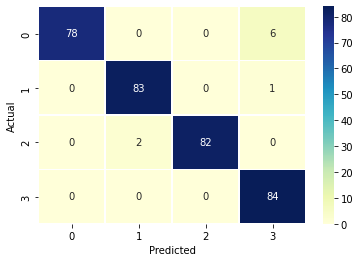

In [ ]:
import pandas as pd
import seaborn as sn

data= pd.DataFrame({'y_true':y_true,
                    'y_pred':y_pred})
data[data['y_true']!=data['y_pred']]
# DF= pd.DataFrame({'0':'Angioectasia',str(1):'Inflamatory',str(2):'Normal', str(3):'Vascular lesion'})

confusion_matrix = pd.crosstab(data['y_true'], data['y_pred'],
                               rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

sn.heatmap(confusion_matrix, annot=True, fmt='d',linewidths=.5, cmap="YlGnBu")
plt.show()

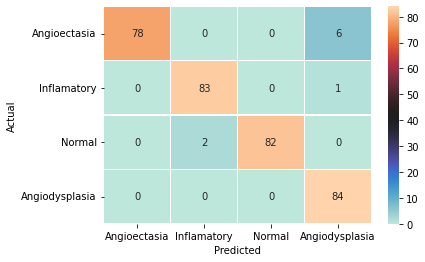

In [ ]:
import pandas as pd
import seaborn as sn

data= pd.DataFrame({'y_true':y_true,
                    'y_pred':y_pred})

confusion_matrix = pd.crosstab(data['y_true'], data['y_pred'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix.rename(columns={0: 'Angioectasia', 1: 'Inflamatory', 2:'Normal', 3: 'Angiodysplasia'}, inplace=True)
confusion_matrix.rename(index={0: 'Angioectasia', 1: 'Inflamatory', 2:'Normal', 3: 'Angiodysplasia'}, inplace=True)

confusion_matrix
sn.color_palette("tab10")
sn.heatmap(confusion_matrix, annot=True, fmt='d',linewidths=.5, cmap='icefire')
plt.show()

In [ ]:
print(test_generator.class_indices.keys())
print(train_generator.class_indices.keys())

dict_keys(['Angiectasia', 'Inflammatory', 'Normal', 'Vascular_lesion'])
dict_keys(['Angiectasia', 'Inflammatory', 'Normal', 'Vascular_lesion'])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras import metrics
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix

## Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
from keras import metrics
# Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
# y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(test_generator.class_indices.keys()) #['vascular lesions', 'normal', 'inflamatory', 'angiectasia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
results = confusion_matrix(y_true, y_pred)

print(results)
# cm=confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

Confusion Matrix
[[78  0  0  6]
 [ 0 83  0  1]
 [ 0  2 82  0]
 [ 0  0  0 84]]
Classification Report
                 precision    recall  f1-score   support

    Angiectasia       1.00      0.93      0.96        84
   Inflammatory       0.98      0.99      0.98        84
         Normal       1.00      0.98      0.99        84
Vascular_lesion       0.92      1.00      0.96        84

       accuracy                           0.97       336
      macro avg       0.97      0.97      0.97       336
   weighted avg       0.97      0.97      0.97       336

[[78  0  0  6]
 [ 0 83  0  1]
 [ 0  2 82  0]
 [ 0  0  0 84]]


## call the saved weights

In [ ]:
# checkpoint_path= '/drive/MyDrive/DL Codes/exception_trial_1.hdf5'
model.load_weights(checkpoint_path)
new_model=model

# other pathogies

## ulcer

In [ ]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_ulcer_dir='/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_ulcer'
test_ulcer_content_dir= '/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_ulcer/ulcer_rename'
len_ulcer= (len(os.listdir(test_ulcer_content_dir)))
test_generator = test_datagen.flow_from_directory(test_ulcer_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=1,
                                                  shuffle= False,
                                                  class_mode='categorical')

Found 854 images belonging to 1 classes.


In [ ]:
import cv2
import numpy as np
dim = (input_size,input_size)

pred=[]
for i in range(len_ulcer):
  image,target=next(test_generator)
  ypred = new_model.predict(image)
  ypred= np.argmax(ypred, axis=1)
  #print(ypred)
  pred.append(ypred[0])

df= pd.DataFrame(pred, columns=['predicted'])
print(len(df[df['predicted']==0]))
print(len(df[df['predicted']==1]))
print(len(df[df['predicted']==2]))
print(len(df[df['predicted']==3]))
print('NPV: ', len(df[df['predicted']!=2])/len(df))

449
382
6
17
NPV:  0.9929742388758782


## erosion

In [ ]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_erosion_dir='/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_erosion'
test_erosion_content_dir= '/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_erosion/erosion_rename'
len_erosion= (len(os.listdir(test_erosion_content_dir)))
test_generator = test_datagen.flow_from_directory(test_erosion_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=1,
                                                  shuffle= False,
                                                  class_mode='categorical')

Found 438 images belonging to 1 classes.


In [ ]:
import cv2
import numpy as np
dim = (input_size,input_size)
pred=[]
for i in range(len_erosion):
  image,target=next(test_generator)
  ypred = new_model.predict(image)
  ypred= np.argmax(ypred, axis=1)
  #print(ypred)
  pred.append(ypred[0])

df= pd.DataFrame(pred, columns=['predicted'])
print(len(df[df['predicted']==0]))
print(len(df[df['predicted']==1]))
print(len(df[df['predicted']==2]))
print(len(df[df['predicted']==3]))
print('NPV: ', len(df[df['predicted']!=2])/len(df))

292
108
10
28
NPV:  0.9771689497716894


## polyp

In [ ]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_polyp_dir='/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_polyp'
test_polyp_content_dir= '/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_polyp/Polyp'
len_polyp= (len(os.listdir(test_polyp_content_dir)))
test_generator = test_datagen.flow_from_directory(test_polyp_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=1,
                                                  shuffle= False,
                                                  class_mode='categorical')

Found 64 images belonging to 1 classes.


In [ ]:
import cv2
import numpy as np
dim = (input_size,input_size)
pred=[]
for i in range(len_polyp):
  image,target=next(test_generator)
  ypred = new_model.predict(image)
  ypred= np.argmax(ypred, axis=1)
  #print(ypred)
  pred.append(ypred[0])

df= pd.DataFrame(pred, columns=['predicted'])
print(len(df[df['predicted']==0]))
print(len(df[df['predicted']==1]))
print(len(df[df['predicted']==2]))
print(len(df[df['predicted']==3]))
print('NPV: ', len(df[df['predicted']!=2])/len(df))

55
1
8
0
NPV:  0.875


## blood

In [ ]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_blood_dir='/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_blood'
test_blood_content_dir= '/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_blood/Blood'
len_blood= (len(os.listdir(test_blood_content_dir)))
test_generator = test_datagen.flow_from_directory(test_blood_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=1,
                                                  shuffle= False,
                                                  class_mode='categorical')

Found 419 images belonging to 1 classes.


In [ ]:
import cv2
import numpy as np
dim = (input_size,input_size)
pred=[]
for i in range(len_blood):
  image,target=next(test_generator)
  ypred = new_model.predict(image)
  ypred= np.argmax(ypred, axis=1)
  #print(ypred)
  pred.append(ypred[0])

df= pd.DataFrame(pred, columns=['predicted'])
print(len(df[df['predicted']==0]))
print(len(df[df['predicted']==1]))
print(len(df[df['predicted']==2]))
print(len(df[df['predicted']==3]))
print('NPV: ', len(df[df['predicted']!=2])/len(df))

413
0
1
5
NPV:  0.9976133651551312


## erythema

In [ ]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_erythema_dir='/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_erythematous'
test_erythema_content_dir= '/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_erythematous/Erythematous'
len_erythema= (len(os.listdir(test_erythema_content_dir)))
test_generator = test_datagen.flow_from_directory(test_erythema_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=1,
                                                  shuffle= False,
                                                  class_mode='categorical')

Found 238 images belonging to 1 classes.


In [ ]:
import cv2
import numpy as np
dim = (input_size,input_size)
pred=[]
for i in range(len_erythema):
  image,target=next(test_generator)
  ypred = new_model.predict(image)
  ypred= np.argmax(ypred, axis=1)
  #print(ypred)
  pred.append(ypred[0])

df= pd.DataFrame(pred, columns=['predicted'])
print(len(df[df['predicted']==0]))
print(len(df[df['predicted']==1]))
print(len(df[df['predicted']==2]))
print(len(df[df['predicted']==3]))
print('NPV: ', len(df[df['predicted']!=2])/len(df))

178
54
0
6
NPV:  1.0


## Lymphoid Hyperplasia

In [ ]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_lymphhyperplasia_dir='/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_lymphoidhyperplasia'
test_lymphhyperplasia_content_dir= '/drive/MyDrive/WCE/ANGIODYSPLASIA DETECTION AND LOCALIZATION/angiodysplasia/test_lymphoidhyperplasia/Lymphoid Hyperplasia'
len_lymphhyperplasia= (len(os.listdir(test_lymphhyperplasia_content_dir)))
test_generator = test_datagen.flow_from_directory(test_lymphhyperplasia_dir,
                                                  target_size=(input_size, input_size),
                                                  batch_size=1,
                                                  shuffle= False,
                                                  class_mode='categorical')

Found 592 images belonging to 1 classes.


In [ ]:
import cv2
import numpy as np
dim = (input_size,input_size)
pred=[]
for i in range(len_lymphhyperplasia):
  image,target=next(test_generator)
  ypred = new_model.predict(image)
  ypred= np.argmax(ypred, axis=1)
  #print(ypred)
  pred.append(ypred[0])

df= pd.DataFrame(pred, columns=['predicted'])
print(len(df[df['predicted']==0]))
print(len(df[df['predicted']==1]))
print(len(df[df['predicted']==2]))
print(len(df[df['predicted']==3]))
print('NPV: ', len(df[df['predicted']!=2])/len(df))

579
7
0
6
NPV:  1.0
